# Attempt to implement MLP for forecasting carbon intensity

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [17]:
df = pd.read_csv('../data/df_fuel_ckan.csv')
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df_monthly = df.set_index('DATETIME')['CARBON_INTENSITY'].resample('ME').mean().reset_index()

In [18]:
def create_features(df):
    df = df.copy()
    # Seasonal Lags: 1 month, 2 months, and 12 months (yearly seasonality)
    for l in [1, 2, 3, 12]:
        df[f'lag_{l}'] = df['CARBON_INTENSITY'].shift(l)
    
    df['month'] = df['DATETIME'].dt.month
    df['year'] = df['DATETIME'].dt.year
    return df

df_features = create_features(df_monthly).dropna()

In [19]:
train = df_features[df_features['year'] <= 2024]
val = df_features[df_features['year'] == 2025]

X_train = train.drop(columns=['DATETIME', 'CARBON_INTENSITY'])
y_train = train['CARBON_INTENSITY']
X_val = val.drop(columns=['DATETIME', 'CARBON_INTENSITY'])
y_val = val['CARBON_INTENSITY']

In [20]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale features based on training data only to avoid data leakage
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

# Scale target (requires reshaping for the scaler)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

In [21]:
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32), 
    activation='relu', 
    solver='adam', 
    max_iter=1000, 
    random_state=42
)

mlp.fit(X_train_scaled, y_train_scaled)

MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)

In [22]:
y_pred_scaled = mlp.predict(X_val_scaled)
# Convert back from scaled units to gCO2/kWh
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)

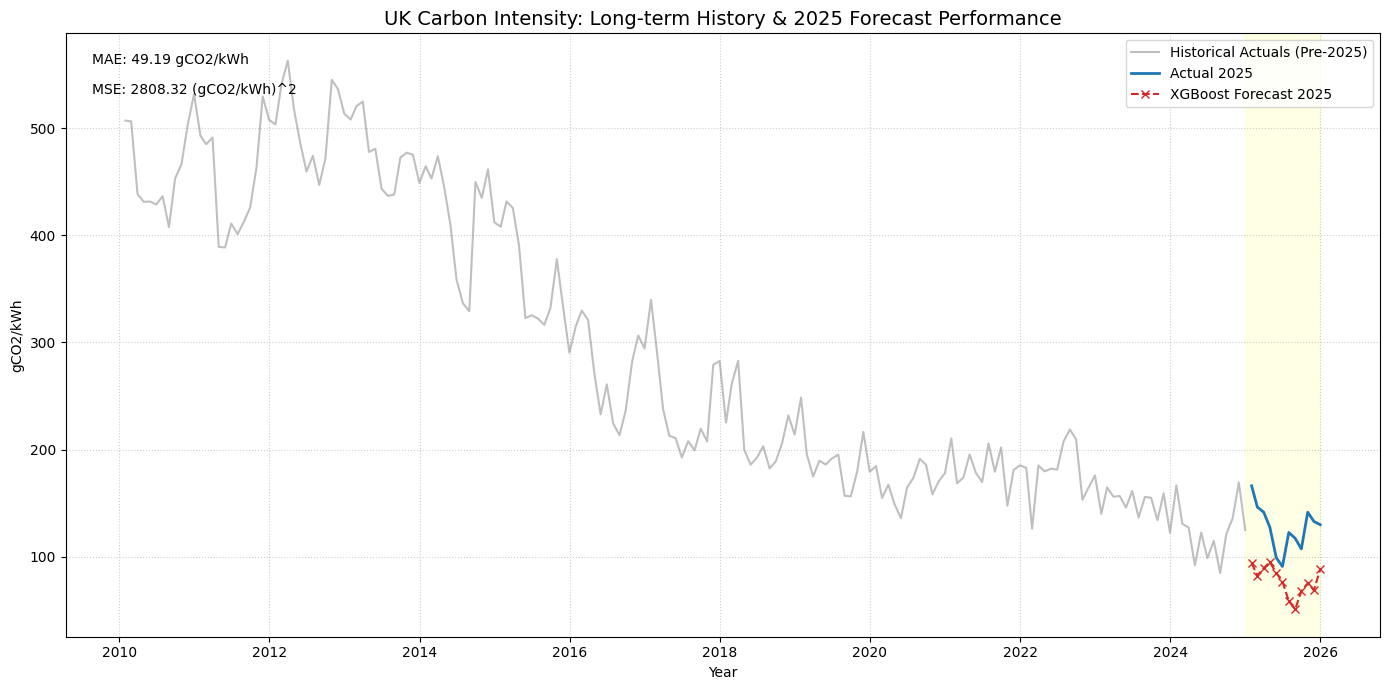

In [23]:
plt.figure(figsize=(14, 7))

plt.plot(train['DATETIME'], train['CARBON_INTENSITY'], 
         color='gray', alpha=0.5, label='Historical Actuals (Pre-2025)')

plt.plot(val['DATETIME'], val['CARBON_INTENSITY'], 
         color='tab:blue', linewidth=2, label='Actual 2025')

plt.plot(val['DATETIME'], y_pred, 
         color='tab:red', linestyle='--', marker='x', label='XGBoost Forecast 2025')

plt.title('UK Carbon Intensity: Long-term History & 2025 Forecast Performance', fontsize=14)
plt.xlabel('Year')
plt.ylabel('gCO2/kWh')
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)

# Highlight the Forecast region
plt.axvspan(pd.Timestamp('2025-01-01'), pd.Timestamp('2025-12-31'), 
            color='yellow', alpha=0.1, label='Forecast Window')
plt.text(0.02, 0.95, "MAE: {:.2f} gCO2/kWh".format(mae), 
         fontsize=10, color='black', transform=plt.gca().transAxes)
plt.text(0.02, 0.90, "MSE: {:.2f} (gCO2/kWh)^2".format(mse), 
         fontsize=10, color='black', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()